In [1]:
import os
import matplotlib.pyplot as plt
import neurolib.optimize.exploration.explorationUtils as eu
import numpy as np
from neurolib.models.multimodel import MultiModel
from neurolib.models.multimodel.builder import HopfNetwork
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.utils.stimulus import ZeroInput

import neurolib.utils.pypetUtils as pu
from scipy.signal import find_peaks

from hopf_cfc_network import SlowFastHopfNetwork
from cfcUtils import *

import neurolib_funcs.optimize.exploration.newExplorationUtils as neu
import neurolib_funcs.optimize.exploration.testing_ExplorationUtils as teu

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd

plt.style.use("seaborn")
plt.rcParams['image.cmap'] = 'plasma'

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

# intrinsic frequencies of SlowFastHopfNetwork are:
# slow intrinsic frequency ~ 6Hz
# fast intrinsic frequency ~ 30Hz

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

model = MultiModel(
    SlowFastHopfNetwork(
        number_of_slow_fast_units=1,
        slow_to_fast_connection=0.1,
        fast_to_slow_connection=0.05,
    )
)

model.params["duration"] = 20.0 * 1000
model.params["sampling_dt"] = DT
model.params["dt"] = 0.01  # ms - lower dt for numba backend
# numba backend is the way to go in exploration - much faster
model.params["backend"] = "numba"

# manually add params you want to change during exploration, btw model.params is just a dictionary, so you can add whatever :)
model.params["coupling"] = "multiplicative"
model.params["slow_to_fast"] = 0.0
model.params["fast_to_slow"] = 0.0

In [3]:
parameters = ParameterSpace(
    {
        "slow_to_fast": np.linspace(0.0, 10., 10),
        "fast_to_slow": np.linspace(0.0, 10., 10),
        "coupling":["additive","diffusive","multiplicative"],

    }
    ,allow_star_notation=True,
    kind="grid",)

In [4]:
def evaluateSimulation(traj):
    # get model with parameters for this run
    model = search.getModelFromTraj(traj)
    # extract stuff you want
    coupling = model.params["coupling"]

    s_f_conn = model.params["slow_to_fast"]
    f_s_conn = model.params["fast_to_slow"]

    model.params["*connectivity"] = np.array([[0.0, f_s_conn], [s_f_conn, 0.0]])

    model.model_instance.default_coupling = {'network_x': coupling, 'network_y':coupling}

    model.run()


    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=60, spectrum_windowsize=1)
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=60, spectrum_windowsize=1)

    peaks_fast, _ = find_peaks(pow_fast, height=max(1e-3, 1.0 * np.std(pow_fast)))
    peaks_slow, _ = find_peaks(pow_slow, height=max(1e-3, 0.5 * np.std(pow_slow)))

    if (np.allclose(np.asarray(model.x.T[100000:150000, 0]), np.asarray(model.x.T[150000:, 0]), rtol=1e-3) and
            (np.allclose(np.asarray(model.x.T[100000:150000, 1]), np.asarray(model.x.T[150000:, 1]), rtol=1e-3))):

        # that is, if in the last 10 seconds of the simulation are in a constant value, then we
        # are in a fixed point, there's no oscillation --> we're not interested
        mi = np.nan
        mvl = np.nan
        plv = np.nan
        minfo = np.nan
        p_value_mi = np.nan
        p_value_mvl = np.nan
        p_value_plv = np.nan
        p_value_minfo = np.nan

    else:
        phase_slow = np.arctan2(model.y[0, :], model.x[0, :])
        phase_fast = np.arctan2(model.y[1, :], model.x[1, :])
        amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)

        mi = modulation_index_general(amp_fast, phase_slow, n_bins=18)
        mvl, _ = mean_vector_length(amp_fast, phase_slow)
        plv, _ = phase_locking_value(phase_fast, phase_slow)
        minfo = mutual_information(phase_fast, phase_slow, bins=16, log2=False)

        p_value_mi, p_value_mvl, p_value_plv, p_value_minfo = compute_p_values(x_slow=model.x[0, :],
                                y_slow=model.y[0, :], t=model.t, measured_mi=mi, measured_mvl=mvl,
                                measured_plv=plv, measured_minfo=minfo, amp_fast=amp_fast, phase_fast=phase_fast)

    result_dict = {
            "peaks_freq_fast": peaks_fast,
            "peaks_freq_slow": peaks_slow,
            "modulation_index": mi,
            "mean_vector_length_abs": mvl,
            "phase_locking_value_abs": plv,
            "mutual_information": minfo,
            "p_value_mi": p_value_mi,
            "p_value_mvl": p_value_mvl,
            "p_value_plv": p_value_plv,
            "p_value_minfo": p_value_minfo

        }

    search.saveToPypet(result_dict, traj)

In [5]:
search = BoxSearch(
    model=model,
    evalFunction=evaluateSimulation,
    parameterSpace=parameters,
    filename="Hopf_1d_conn_test_wPeaks.hdf",
    ncores=6,
)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 300
MainProcess root INFO     BoxSearch: Environment initialized.


In [6]:
search.run()

In [7]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/Hopf_1d_conn_test_wPeaks.hdf
MainProcess root INFO     Analyzing trajectory results-2022-06-03-17H-00M-12S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-06-03-17H-00M-12S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 300/300 [00:03<00:00, 94.44it/s] 
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 300/300 [00:00<00:00, 109

In [8]:
search.dfResults

,slow_to_fast,fast_to_slow,coupling,phase_locking_value_abs,peaks_freq_slow,peaks_freq_fast,p_value_plv,p_value_mvl,p_value_minfo,p_value_mi,mutual_information,modulation_index,mean_vector_length_abs
0,0.0,0.000000,additive,0.000501,[6],[32],0.964,0.236,0.004,0.798,1.083589,4.461571e-10,0.001069
1,0.0,0.000000,diffusive,0.000501,[6],[32],0.964,0.236,0.004,0.798,1.083589,4.461571e-10,0.001069
2,0.0,0.000000,multiplicative,0.000501,[6],[32],0.964,0.236,0.004,0.798,1.083589,4.461571e-10,0.001069
3,0.0,1.111111,additive,0.999991,[32],[32],0.000,0.368,0.094,0.118,2.143704,2.907717e-10,0.000260
4,0.0,1.111111,diffusive,0.999996,[32],[32],0.000,0.392,0.122,0.164,2.116070,2.833168e-10,0.000246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,10.0,8.888889,diffusive,1.000000,[18],[18],0.000,0.108,0.010,0.942,2.666794,6.574053e-10,0.000023
296,10.0,8.888889,multiplicative,0.999997,"[7, 11, 38, 43]","[4, 7, 11, 16, 18, 24, 26, 31, 34, 40, 44, 52,...",0.000,0.000,0.000,0.000,1.535136,7.927980e-01,8.869283
297,10.0,10.000000,additive,1.000000,[19],[19],0.000,0.124,0.008,0.968,2.673856,1.117240e-10,0.000263
298,10.0,10.000000,diffusive,1.000000,[19],[19],0.000,0.170,0.008,0.998,2.673546,5.022192e-10,0.000047


In [32]:
np.unique((search.dfResults["slow_to_fast"]))

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

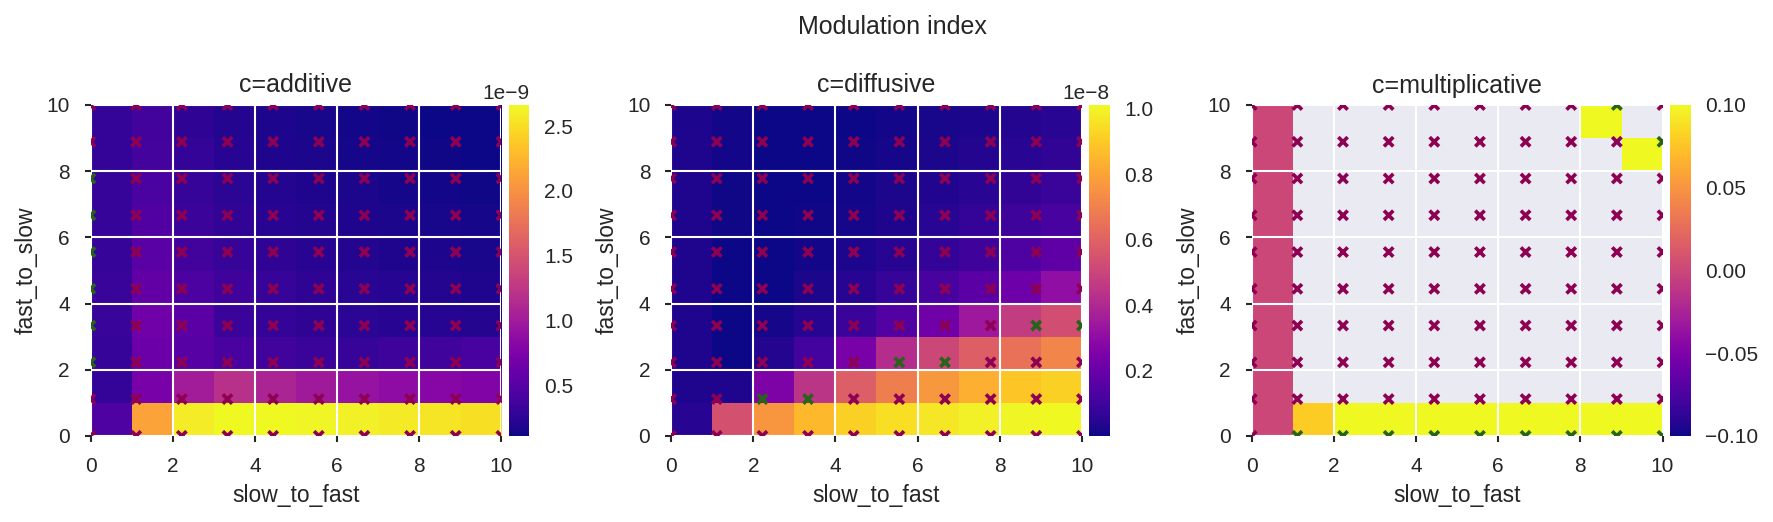

In [34]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="modulation_index",
    nan_to_zero=True,
    by="coupling",
    one_figure=True,
    plot_key_label="Modulation index",
    p_vals=True,
    p_vals_label="p_value_mi",
)


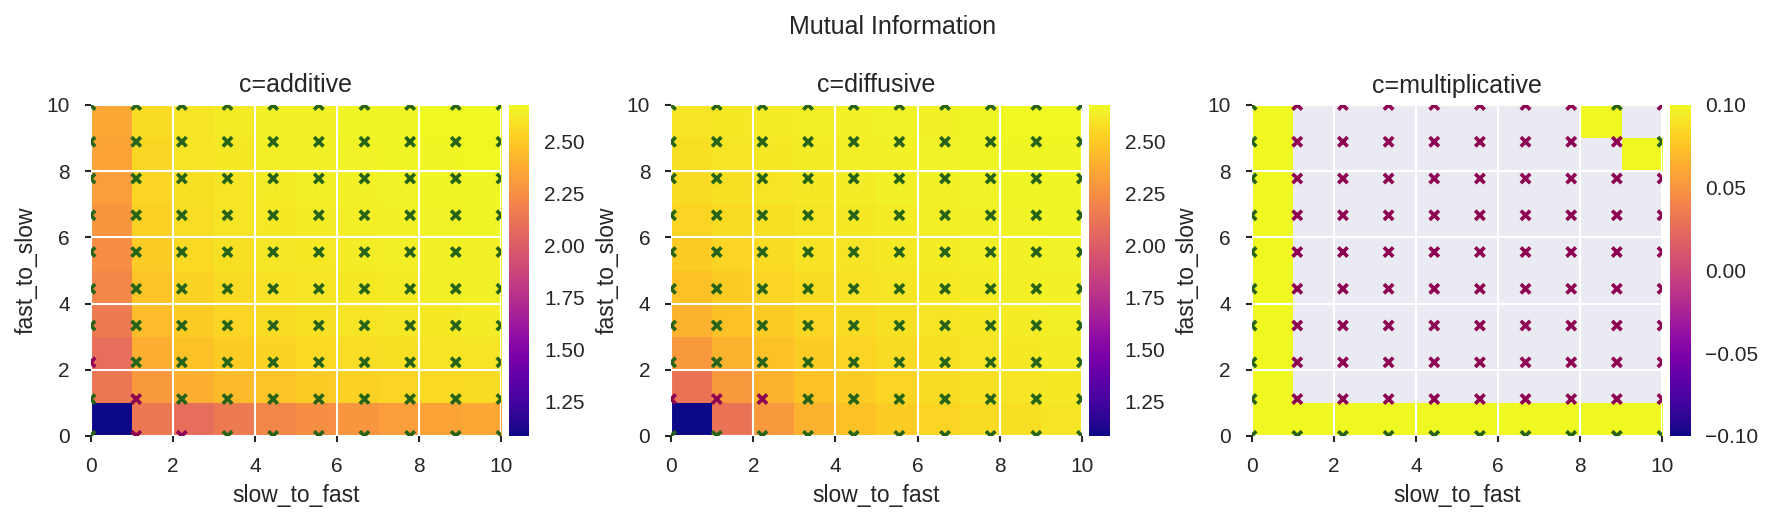

In [35]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="mutual_information",
    nan_to_zero=True,
    by="coupling",
    one_figure=True,
    plot_key_label="Mutual Information",
    p_vals=True,
    p_vals_label="p_value_minfo",
)

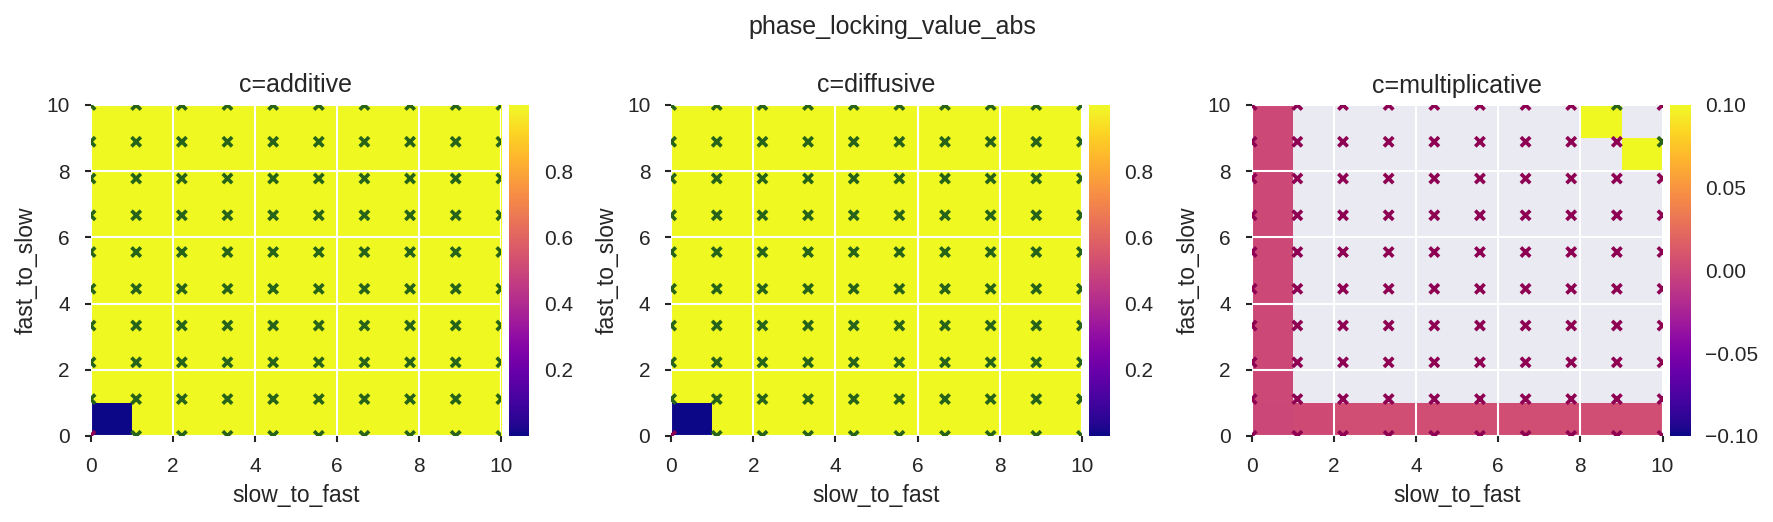

In [36]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="phase_locking_value_abs",
    nan_to_zero=True,
    by="coupling",
    one_figure=True,
    plot_key_label="phase_locking_value_abs",
    p_vals=True,
    p_vals_label="p_value_plv",
)

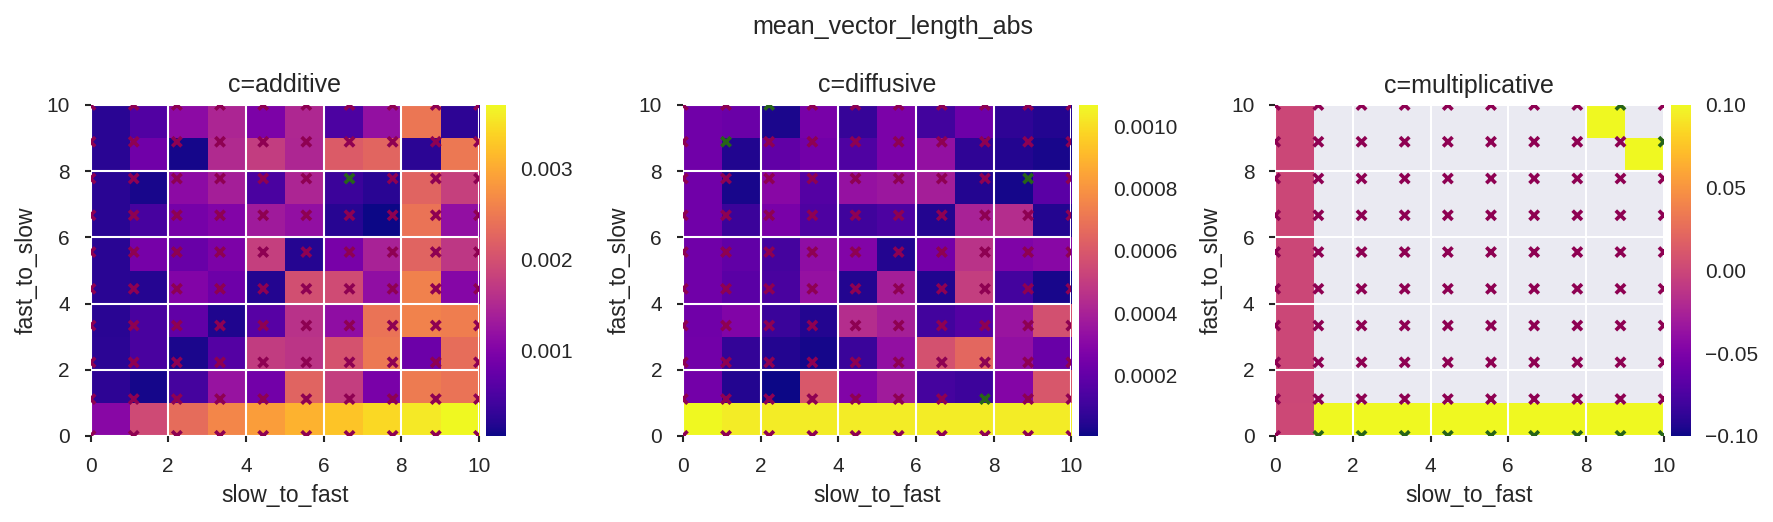

In [37]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="mean_vector_length_abs",
    nan_to_zero=True,
    by="coupling",
    one_figure=True,
    plot_key_label="mean_vector_length_abs",
    p_vals=True,
    p_vals_label="p_value_mvl",
)

I now want to compare the time series, and see what was different

In [13]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms
def simulate(slow_to_fast_conn=0.1,fast_to_slow_conn=.05, frequency_fast = 0.2, frequency_slow = 0.04, coupling = "multiplicative"):
    model = MultiModel(
        SlowFastHopfNetwork(
            number_of_slow_fast_units=1,
            slow_to_fast_connection=slow_to_fast_conn,
            fast_to_slow_connection=fast_to_slow_conn,
        )
    )
    model.params["duration"] = 20.0 * 1000
    model.params["sampling_dt"] = DT
    model.params["dt"] = DT
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.w'] = frequency_slow
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.w'] = frequency_fast

    model.model_instance.default_coupling = {'network_x': coupling, 'network_y':coupling}
    model.run()

    return model

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
MainProcess root INFO     Compiling to C...
/tmp/tmp9i0dao1_/jitced.c: In function ‘get_past_anchors’:
/tmp/tmp9i0dao1_/jitced.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmp9i0dao1_/jitced.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(p

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampl

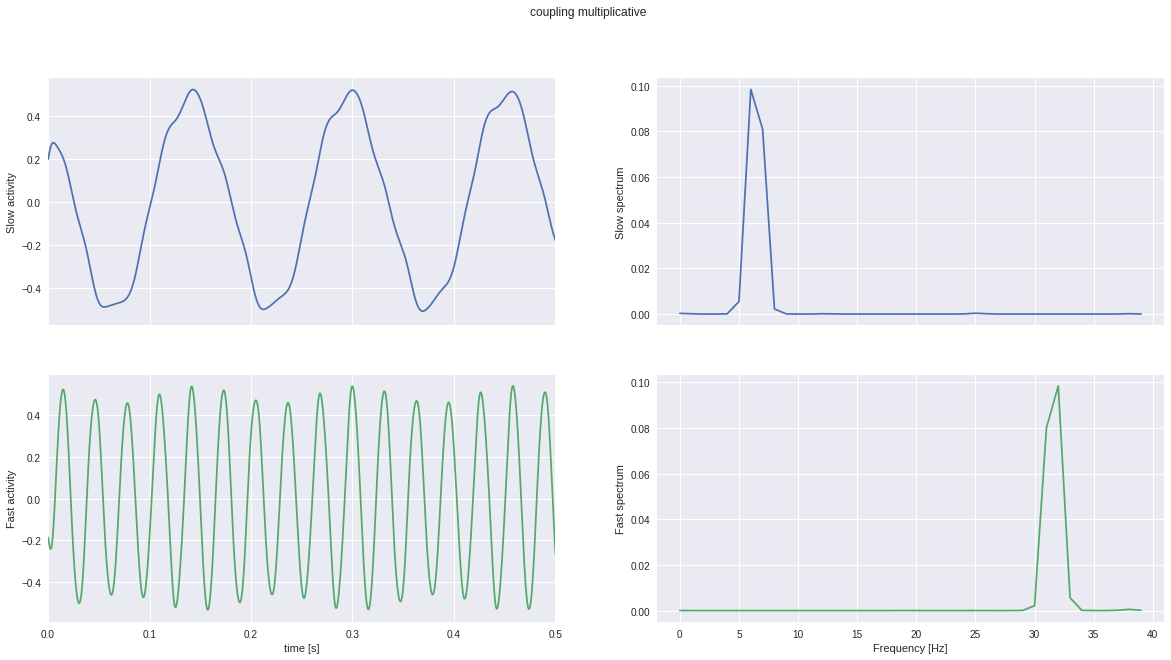

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
MainProcess root INFO     Compiling to C...
/tmp/tmp0q2edc8s/jitced_1.c: In function ‘get_past_anchors’:
/tmp/tmp0q2edc8s/jitced_1.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmp0q2edc8s/jitced_1.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp crit

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampl

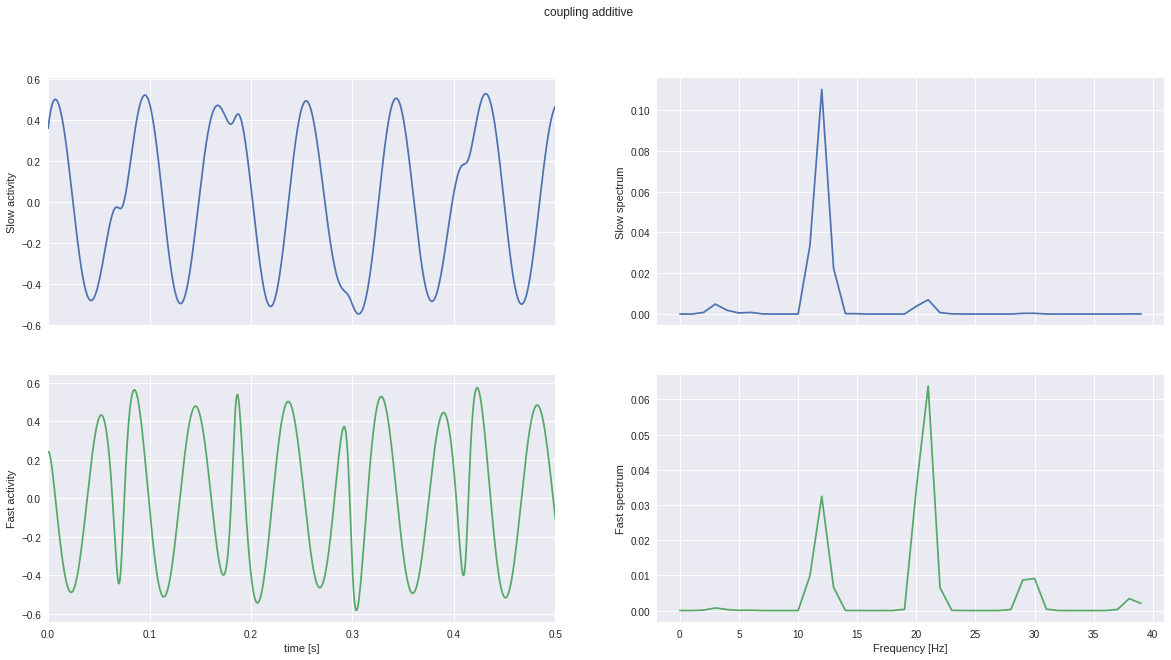

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
MainProcess root INFO     Compiling to C...
/tmp/tmpdrxy7ed8/jitced_2.c: In function ‘get_past_anchors’:
/tmp/tmpdrxy7ed8/jitced_2.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmpdrxy7ed8/jitced_2.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp crit

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampl

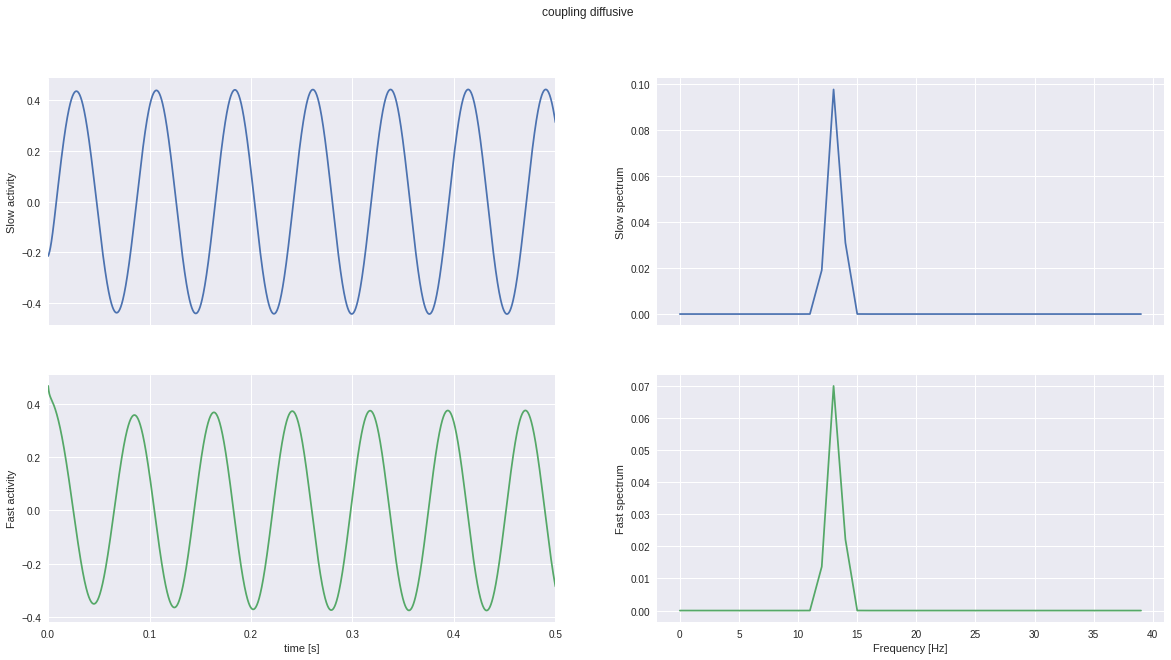

In [14]:
coupling = ["multiplicative","additive","diffusive"]
for c in coupling:
    model = simulate(coupling = c)
    _, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(20, 10))

    axs[0, 0].plot(model.t, model.x.T[:, 0])
    axs[0, 0].set_ylabel("Slow activity")
    axs[1, 0].plot(model.t, model.x.T[:, 1], color="C1")
    axs[1, 0].set_ylabel("Fast activity")
    axs[1, 0].set_xlabel("time [s]")
    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
    axs[0, 1].plot(freq_slow, pow_slow)
    axs[0, 1].set_ylabel("Slow spectrum")
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)
    axs[1, 1].plot(freq_fast, pow_fast, color="C1")
    axs[1, 1].set_ylabel("Fast spectrum")
    axs[1, 1].set_xlabel("Frequency [Hz]")

    axs[0, 0].set_xlim([0, 0.5])
    plt.suptitle(f"coupling {c}")
    plt.show()